<a href="https://colab.research.google.com/github/groccy/US-TW-AI-Projects/blob/main/Image_Auto_Labeler_using_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_collab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
# using_colab = False
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-bawbtj0k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-bawbtj0k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit efeab7296ab579d4a261e554eca80faf6b33924a
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36581 sha256=5a1d9dfa8ec922b71d4590fc247994e35aa641667fc00db5617fa42651c5f419
  Stored in directory: /tmp/pip-ephem-wheel-cache-qxdboqqe/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segm

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

## Example image

In [ ]:
# image = cv2.imread('images/dog.jpg')
image = cv2.imread('images/564_3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

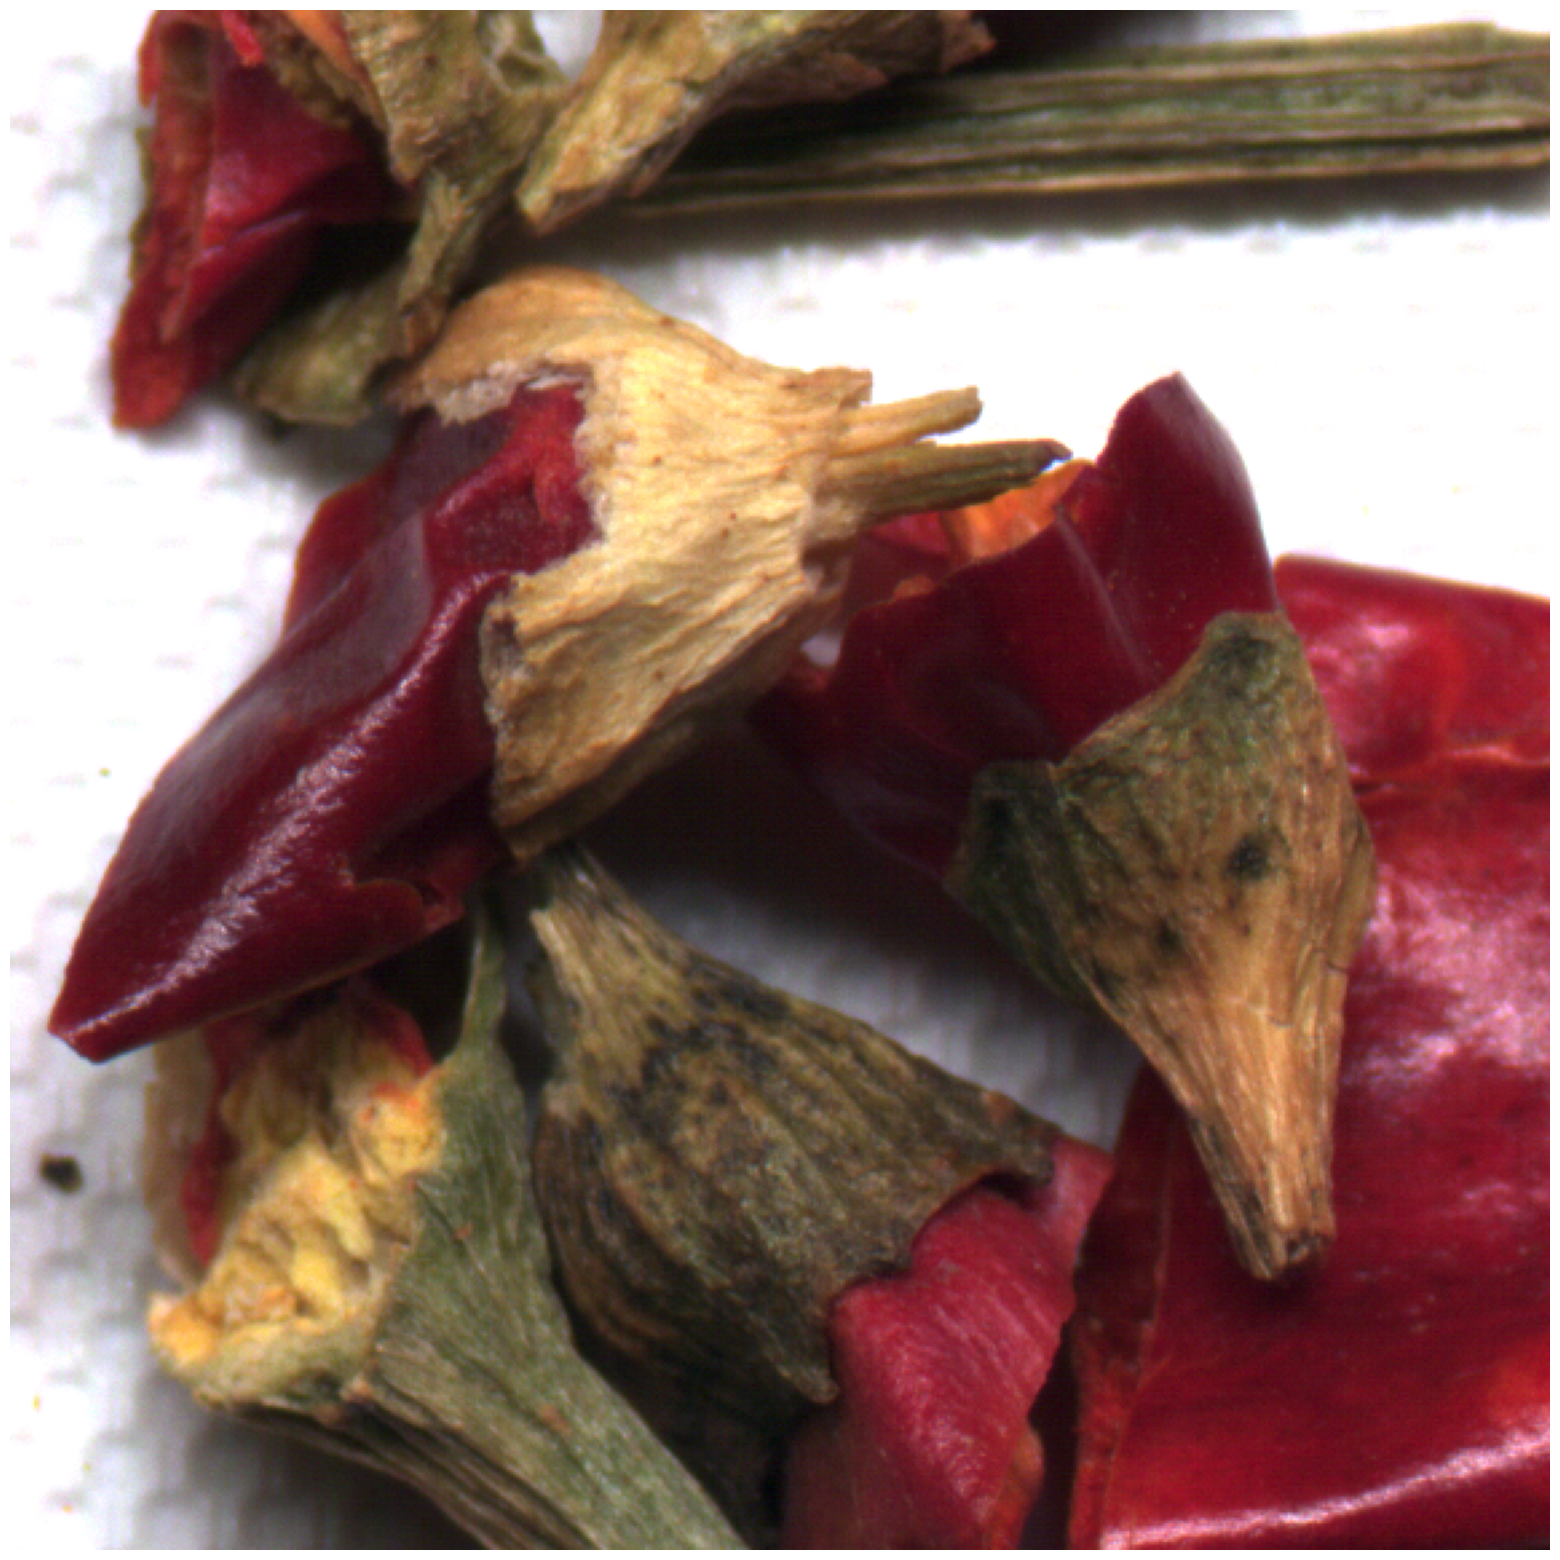

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"

device = "cuda"
model_type = "default"

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

90

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [ ]:
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side= 32,
    pred_iou_thresh= 0.95, #0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area= 2, #100,  # Requires open-cv to run post-processing
)

In [ ]:
mask_generator_4 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side= 5, #32,
    pred_iou_thresh= 0.96, #0.86,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area= 1, #100,  # Requires open-cv to run post-processing
)

In [ ]:
mask_generator_5 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side= 8, #4, #32,
    pred_iou_thresh= 0.9, #0.86,
    stability_score_thresh=0.92, #0.92
    crop_n_layers=1,
    crop_n_points_downscale_factor=2, #2,
    min_mask_region_area= 1, #100,  # Requires open-cv to run post-processing
)

In [ ]:
masks3 = mask_generator_3.generate(image)

In [ ]:
masks4 = mask_generator_4.generate(image)

In [ ]:
masks5 = mask_generator_5.generate(image)

In [ ]:
len(masks3)

17

In [ ]:
len(masks4)

4

In [ ]:
len(masks5)

27

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show() 

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks4)
plt.axis('off')
plt.show() 

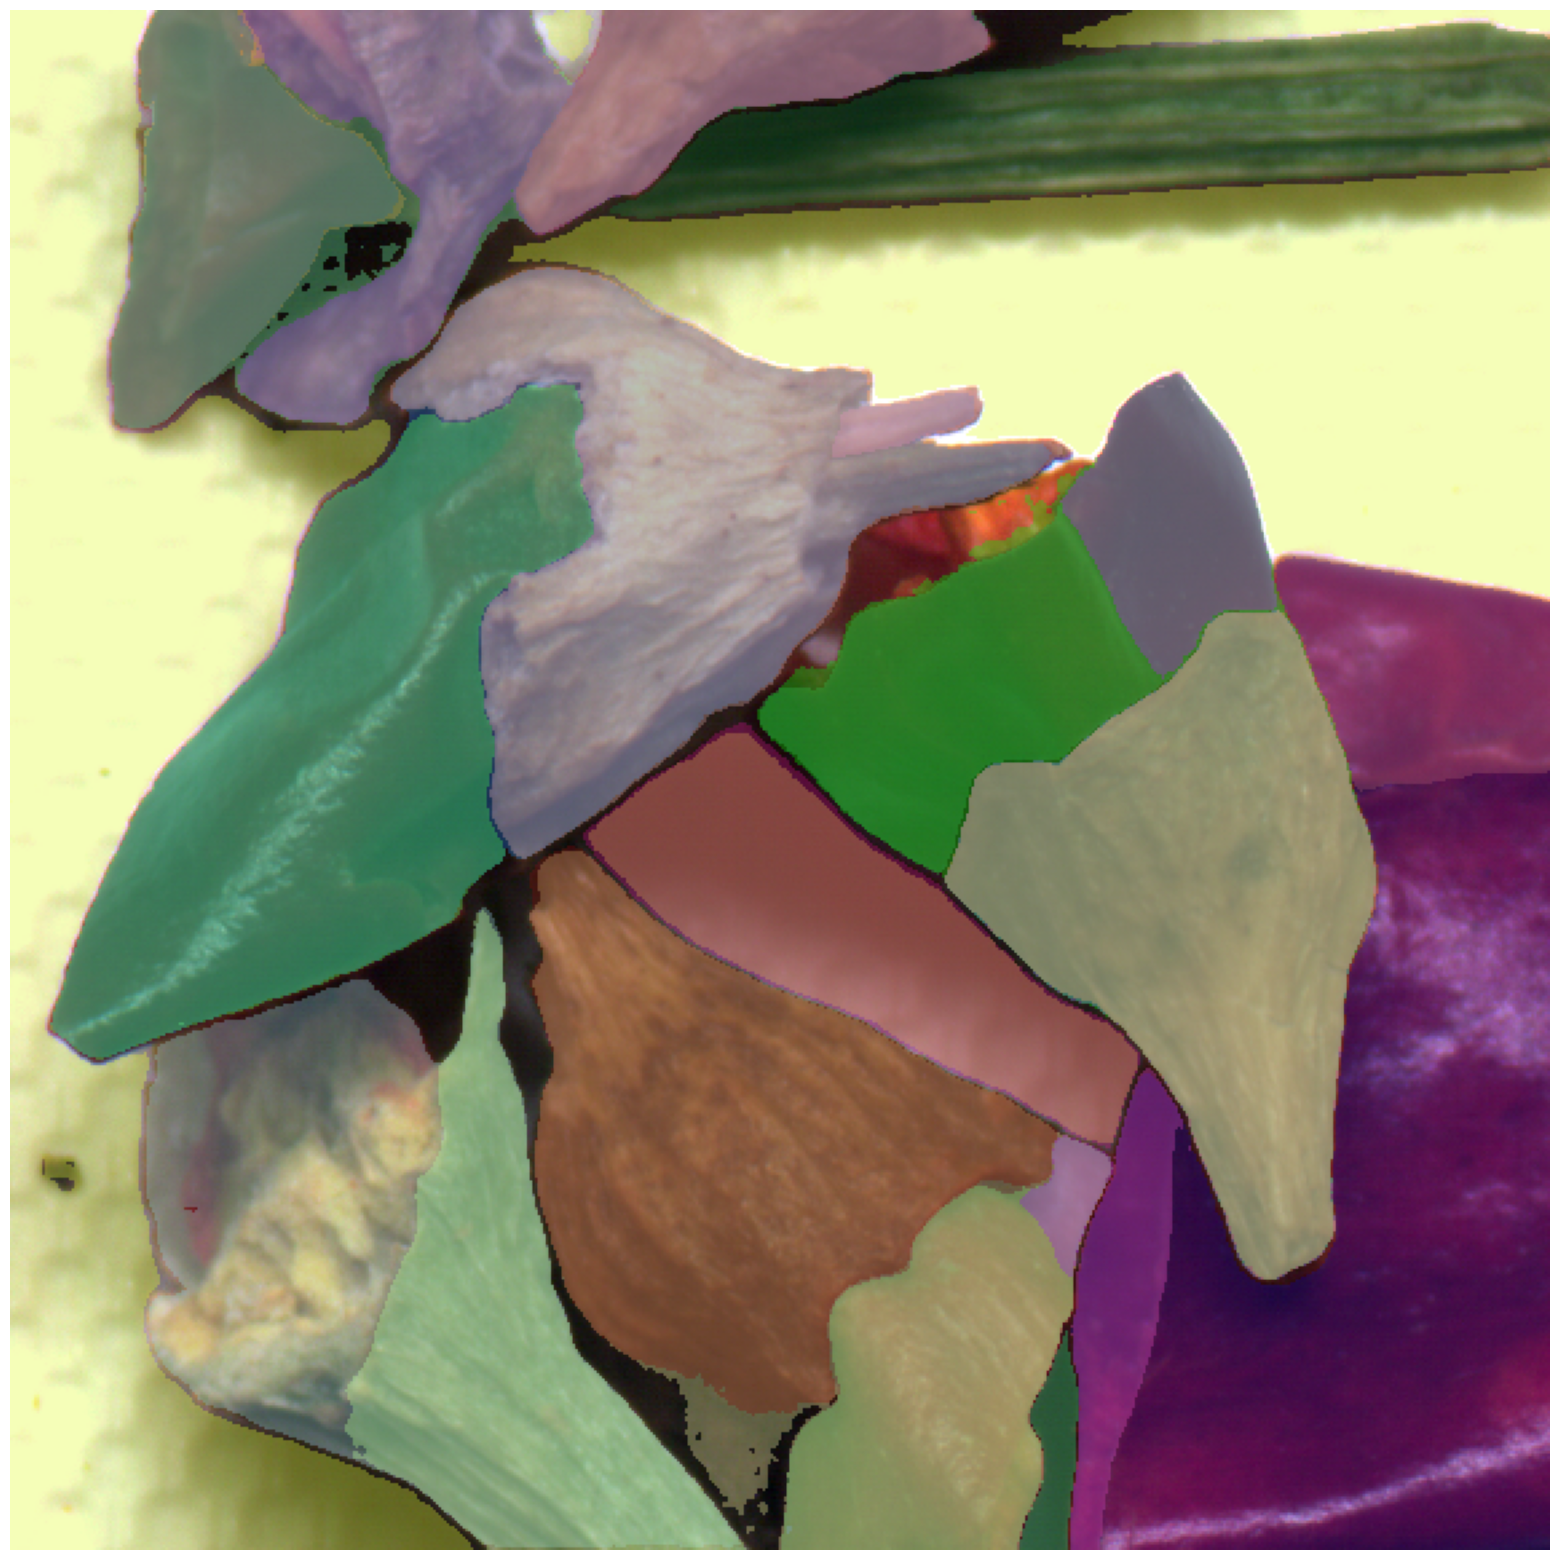

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks5)
plt.axis('off')
plt.show() 

In [ ]:
masks5[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 7194,
 'bbox': [433, 257, 54, 218],
 'predicted_iou': 0.9780312776565552,
 'point_coords': [[478.75, 286.25]],
 'stability_score': 0.9728692770004272,
 'crop_box': [190.0, 190.0, 385.0, 385.0]}

In [ ]:
!pip install imantics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for imantics: filename=imantics-0.1.12-py3-none-any.whl size=16030 sha256=d1c14f9e67704fea70937411cb74a47f0aaedbafedf0c6411dcd21f178606e9d
  Stored in directory: /root/.cache/pip/wheels/45/65/ec/8f8f231fa40bc5d47798df399f65aea84d2e3a0ea296f81506
Successfully built imantics


In [ ]:
from imantics import Polygons, Mask

# img_path = 'path_to_your_img' 
# image = cv2.imread(img_path)
# outputs = predict(image)

# pred_img_mask = masks5[0]['segmentation']*1 #outputs['instances'].pred_masks.numpy()*1
pred_poly_points = []

for i in range(len(masks5)): #(pred_img_mask.shape[0]):
    polygons = Mask(masks5[i]['segmentation']*1).polygons() #Mask(pred_img_mask[i]).polygons()
    pred_poly_points.append((polygons.points)[0])

In [ ]:
!pip install labelme

In [6]:
import base64
import labelme
from labelme import LabelFile

data = labelme.LabelFile.load_image_file('images/564_3.jpg')
img_data = base64.b64encode(data).decode('utf-8')

In [11]:
 out_dict = {"version":"3.15.2",
                    "flags": {},
                    # "shapes" : all_points,
                    "lineColor": [0, 255, 0, 128], 
                    "fillColor": [255, 0, 0, 128],
                    "imagePath": 'images/564_3.jpg', #"../" + img_name + "." + str(i_img) + ".png",
                    "imageData": img_data,
                    # "imageHeight" : img_size,
                    # "imageWidth" : img_size,
                 }

In [ ]:
masks5[0]['segmentation']*1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
len(masks5)

27

In [ ]:
len(pred_poly_points)

27

In [ ]:
pred_poly_points

[array([[473, 224],
        [472, 225],
        [453, 225],
        [452, 226],
        [451, 226],
        [448, 229],
        [447, 229],
        [447, 230],
        [446, 231],
        [446, 233],
        [445, 234],
        [445, 236],
        [444, 237],
        [444, 238],
        [438, 244],
        [438, 245],
        [437, 246],
        [436, 246],
        [436, 247],
        [431, 252],
        [430, 252],
        [427, 255],
        [426, 255],
        [425, 256],
        [424, 256],
        [422, 258],
        [421, 258],
        [419, 260],
        [418, 260],
        [417, 261],
        [416, 261],
        [414, 263],
        [413, 263],
        [412, 264],
        [411, 264],
        [407, 268],
        [406, 268],
        [401, 273],
        [400, 273],
        [391, 282],
        [389, 282],
        [388, 281],
        [370, 281],
        [369, 282],
        [366, 282],
        [365, 283],
        [364, 283],
        [362, 285],
        [361, 285],
        [361, 286],


In [12]:
out_dict

{'version': '3.15.2',
 'flags': {},
 'lineColor': [0, 255, 0, 128],
 'fillColor': [255, 0, 0, 128],
 'imagePath': 'images/564_3.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAI/Aj8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKjmlWG